In [5]:
import pickle
import pandas as pd
from pathlib import Path

from constants import *

In [ ]:
TEXT_DATA_FOLDER = "./../data/text_data/"

#  --- output:  max words and folder ---

# We will use:
# small     (200 words)
# medium  (1_000 words)
# large  (10_000 words)


MAX_WORDS = 10_000 
OUTPUT_FOLDER_NAME = "large (10_000 words)"

In [ ]:
# Use GVKEY as 

# - gvkey identifies the company-level entity in Compustat. Statements tied to a gvkey are for the issuer (equity) rather than a specific security.
# - CUSIP identifies a specific security (issue-level), so it’s too granular.
# - CIK identifies the SEC registrant (issuer), but filings can include multiple securities and entity structures; for linking to standardized financial statements for the equity issuer, gvkey is the conventional company identifier.
# - index, date, file_type, rf, mgmt, year are not identifiers of the issuer vs. security.

# for gvkey, group in gvkey_groups:
#     print(group)

import re
from typing import Iterable

DEFAULT_STOPWORDS = {
    "a","an","the","and","or","but","if","then","than","so","because","as",
    "of","at","by","for","with","about","into","through","during","before",
    "after","above","below","to","from","up","down","in","out","on","off",
    "over","under","again","further","once","here","there","when","where",
    "why","how","all","any","both","each","few","more","most","other",
    "some","such","no","nor","not","only","own","same","so","too","very",
    "can","will","just","don","should","now","is","am","are","was","were",
    "be","been","being","do","does","did","doing","have","has","had","having",
    "this","that","these","those","i","you","he","she","it","we","they","them",
    "their","our","your","yours","ours","his","her","its","my","me","us"
}

def clean_text(
    s: str,
    keep: Iterable[str] = (
        ".", ",", "-", "—", "'", "’", "%", "(", ")", "&", ":", ";", "/", '"'
    ),
    max_words = MAX_WORDS
) -> str:
    s = s.strip()
    s = s.lower()

    # Normalize unicode dashes and quotes to ASCII equivalents
    s = (
        s.replace("—", "-")
         .replace("–", "-")
         .replace("’", "'")
         .replace("“", '"')
         .replace("”", '"')
    )

    s = s.replace("\r", " ").replace("\n", " ").replace("\t", " ")

    # Collapse any whitespace to a single space
    s = re.sub(r"\s+", " ", s).strip()

    keep_set = set(keep)
    escaped_keep = "".join(re.escape(ch) for ch in keep_set)

    # Remove any character that is not a letter, digit, space, or in keep list
    s = re.sub(rf"[^0-9A-Za-z {escaped_keep}]", " ", s)

    # Collapse spaces around punctuation
    s = re.sub(r"\s*([,.;:()/%&/\"'-])\s*", r"\1 ", s)

    # Collapse multiple dashes
    s = re.sub(r"-{2,}", "-", s)

    # Collapse repeated punctuation (e.g., "???" -> "?")
    s = re.sub(r"([,.;:!?/])\1+", r"\1", s)

    # Re-collapse whitespace after punctuation normalization
    s = re.sub(r"\s+", " ", s).strip()

    # Tokenize on spaces
    tokens = s.split()
    
    # Strip simple leading/trailing punctuation around tokens for stopword match
    def strip_punct(tok: str) -> str:
        return tok.strip(".,;:()\"'/%-")
    filtered = [t for t in tokens if strip_punct(t) not in DEFAULT_STOPWORDS][:max_words]
    s = " ".join(filtered)

    return s

for i in range(5, 26):
    file_path = TEXT_DATA_FOLDER + f"text_us_20{i:02d}.pkl"
    with open(file_path, "rb") as f:
        data = pickle.load(f)
        text_data_df = data
        text_data_df = text_data_df.reset_index(inplace=False)

        text_data_df["rf"] = text_data_df["rf"].map(clean_text)
        text_data_df["mgmt"] = text_data_df["mgmt"].map(clean_text)

        temp_path = Path(f"../data/text_data/{OUTPUT_FOLDER_NAME}/text_us_20{i:02d}_preprocessed.csv")
        temp_path.parent.mkdir(parents=True, exist_ok=True)
        
        text_data_df.to_csv(temp_path)

C:\Users\willi\AppData\Local\Temp\ipykernel_21016\3429246131.py:85: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)
C:\Users\willi\AppData\Local\Temp\ipykernel_21016\3429246131.py:85: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access fun

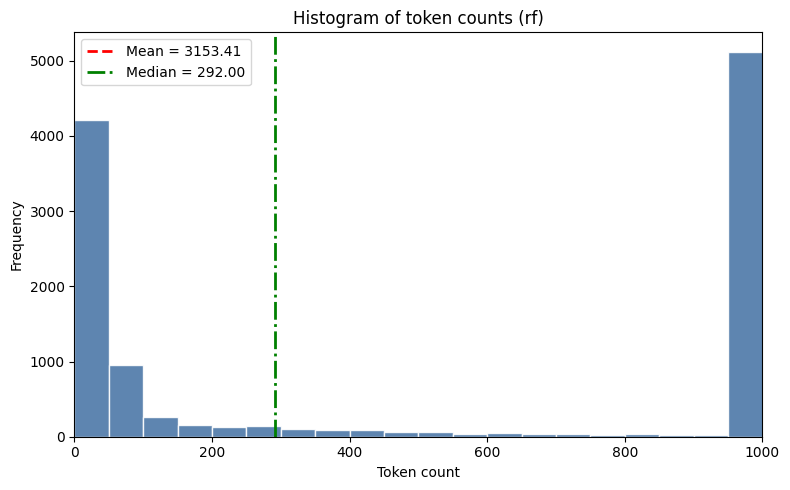

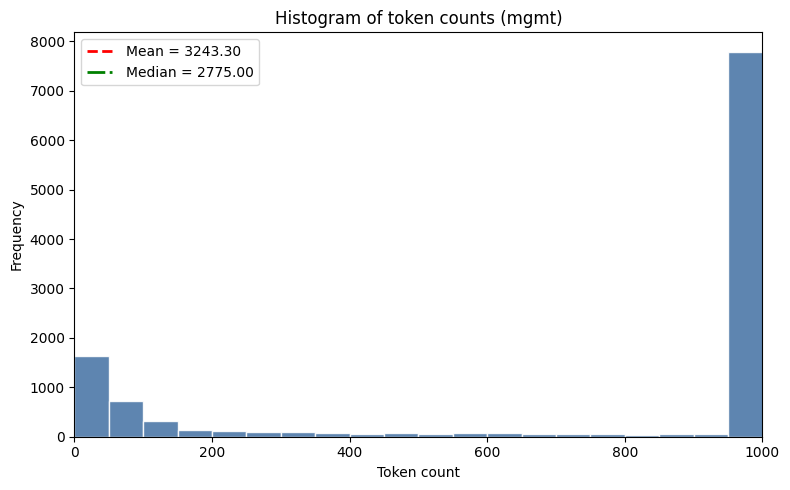

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def create_token_count_hist(column, cumulative, xmin, xmax, bin_width):
    lengths = text_data_df[column].str.split().str.len()

    mean_val = lengths.mean()
    median_val = lengths.median()

    bins = np.arange(lengths.min(), lengths.max() + bin_width, bin_width)
    bins = list(np.arange(lengths.min(), 951, bin_width))
    bins.append(1000000)

    plt.figure(figsize=(8, 5))
    plt.hist(lengths.dropna(), bins=bins, color="#4C78A8", edgecolor="white", alpha=0.9, cumulative=cumulative)

    # Mean and median lines
    plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.2f}")
    plt.axvline(median_val, color="green", linestyle="-.", linewidth=2, label=f"Median = {median_val:.2f}")

    plt.title(f"Histogram of token counts ({column})")
    plt.xlabel("Token count")
    plt.ylabel("Frequency")
    plt.xlim((xmin, xmax))
    plt.legend()
    plt.tight_layout()
    plt.show()

create_token_count_hist("rf", False, 0, 1000, 50)
create_token_count_hist("mgmt", False, 0, 1000, 50)